In [1]:
import os
import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
train_path = os.path.curdir.join(["./data/train/"])
test_path = os.path.curdir.join(["./data/validation/"])

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((100, 100)), 
    transforms.ToTensor()
])

In [5]:
train_data = datasets.ImageFolder(train_path, transform=data_transforms)
validate_data = datasets.ImageFolder(test_path, transform=data_transforms)

In [6]:
train_batch_sizes = []
for size in range(32, 257):
    criteria = len(train_data.imgs) % size
    if criteria == 0:
        train_batch_sizes.append(size)

test_batch_sizes = []
for size in range(32, 257):
    criteria = len(validate_data.imgs) % size
    if criteria == 0:
        test_batch_sizes.append(size)

In [7]:
train_loader = DataLoader(train_data, batch_size=train_batch_sizes[0], shuffle=True)
validate_loader = DataLoader(validate_data, batch_size=test_batch_sizes[0], shuffle=True)

In [8]:
len(validate_loader)

13

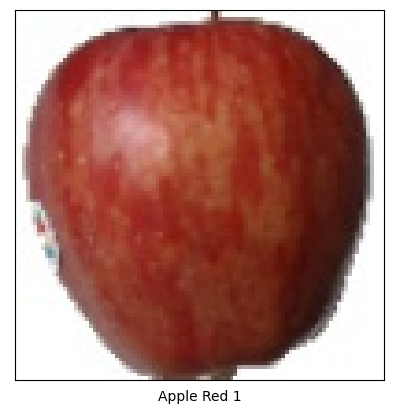

In [9]:
for x, y in train_loader:
    plt.imshow(torchvision.utils.make_grid(x[0], nrow=5).permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(train_data.classes[y[0]])
    break

In [10]:
train_labels = train_data.classes
train_labels

['Apple Red 1', 'Banana', 'Cherry 1']

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5), padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(5, 5), padding=1)
        self.fc1 = torch.nn.Linear(1587, 318)
        self.fc2 = torch.nn.Linear(318, 64)
        self.fc3 = torch.nn.Linear(64, 3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         print('Shape: ', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
#         print('Shape: ', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print('Shape: ', x.shape)
        x = F.relu(self.fc1(x))
#         print('Shape: ', x.shape)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def forward_prop(self, data):
        optimizer.zero_grad()

        output = self.forward(data)

        return output
        
    def backward_prop(self, labels, output):
        self.loss = self.loss_function(output, labels)     
        
        self.loss.backward()
        optimizer.step()

        self.running_loss += self.loss.item()

    def fit(self, train_data, validation_data=None, optimizer=None, 
            loss_function=nn.CrossEntropyLoss(), epochs=5, device='cpu'):
        self.train_data = train_data
        self.validation_data = validation_data
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.epochs = epochs
        self.device = device
#         self.epoch = 0
        self.running_loss = 0
        self.validation_loss = 0
        self.validation_accuracy = 0
        self.to(device)
        self.batch_size = self.train_data.batch_size
        self.start_time = 0
        self.total_time = 0
        self.temp_accuracy = 0
        
    def fit_train(self):
        print('Training...')
        for self.epoch in range(self.epochs):
            self.start_time = time.time()
            
            self.train()
            self.running_loss = 0
            for data, labels in self.train_data:
                self.batch_size = len(data)
                data, labels = data.to(self.device), labels
            
                output = self.forward_prop(data)
                
                self.backward_prop(labels, output)
                
                if self.validation_data is not None:
                    with torch.no_grad():
                        model.eval()
                        self.validation()
                
                self.total_time = time.time() - self.start_time
            self.results()
                
    def validation(self):
        self.validation_loss = 0
        self.validation_accuracy = 0
        for data, labels in self.validation_data:
            data, labels = data.to(self.device), labels
            
            output = self.forward(data)
            self.validation_loss += self.loss_function(output, labels).item()
            
            probabilities = torch.exp(output)
            
            equality = (labels.data == probabilities.max(dim=1)[1])
            
            self.validation_accuracy += equality.type(torch.FloatTensor).mean()
            
    def predict(self, test_data):
        self.eval()
        for data, labels in test_data:
            data = data.to(self.device)
            output = self.forward(data)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
        return probabilities.max(dim=1)[1]
    
    def results(self):
        print(f"Epoch: {self.epoch + 1}/{self.epochs} " 
              f"loss: {self.running_loss/len(self.train_data)} " 
              f"validation loss: {self.validation_loss/len(self.validation_data)} "
              f"validation accuracy: {self.validation_accuracy/len(self.validation_data)} "
              f"time: {int(self.total_time)}s ")

In [20]:
model = Model()

In [21]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
model.fit(train_loader, validation_data=validate_loader, optimizer=optimizer, loss_function=criterion, epochs=2)

In [23]:
model.fit_train()

Training...
Epoch: 1/2 loss: 0.8522297469052401 validation loss: 0.3456360422647916 validation accuracy: 1.0 time: 25s 
Epoch: 2/2 loss: 0.0687098196292275 validation loss: 4.9160008179919365e-05 validation accuracy: 1.0 time: 33s 


In [25]:
path = "./models/model.pth"
torch.save(model.state_dict(), path)

In [26]:
saved_model = Model()
saved_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [27]:
saved_model

Model(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1587, out_features=318, bias=True)
  (fc2): Linear(in_features=318, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)

In [36]:
# test_path = os.path.curdir.join(["./data/test/"])
# test_data = datasets.ImageFolder(test_path, transform=data_transforms)
test_path = "./data/test/"
test_data = datasets.ImageFolder(test_path, transform=data_transforms)

In [37]:
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [38]:
pred = model.predict(test_loader)

In [39]:
pred

tensor([0, 0, 0, 1, 1, 1, 1, 1])

In [40]:
train_data.class_to_idx

{'Apple Red 1': 0, 'Banana': 1, 'Cherry 1': 2}

In [41]:
labels = []
for i in pred:
    for key in train_data.class_to_idx.keys():
        if train_data.class_to_idx[key] == i:
            labels.append(key)
labels

['Apple Red 1',
 'Apple Red 1',
 'Apple Red 1',
 'Banana',
 'Banana',
 'Banana',
 'Banana',
 'Banana']

In [ ]:
..

## Prototypes

In [ ]:
# data split
# train_count = int(0.7 * total_count)
# valid_count = int(0.2 * total_count)
# test_count = total_count - train_count - valid_count
# train_loader, validation_loader, test_loader = torch.utils.data.random_split(train_loader, 
#                                                                              (train_count, valid_count, test_count))

In [ ]:
# model = models.resnet50(pretrained=True)

In [ ]:
# Freeze pretrained model parameters to avoid backpropogating through them
# for parameter in model.parameters():
#     parameter.requires_grad = True


# from collections import OrderedDict

# # Build custom classifier
# classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(250, 100)),
#                                         ('relu', nn.ReLU()),
#                                         ('drop', nn.Dropout(p=0.5)),
#                                         ('fc2', nn.Linear(100, 3)),
#                                         ('output', nn.Softmax(dim=1))]))

# model.classifier = classifier

In [ ]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cpu'), labels.to('cpu')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# from workspace_utils import active_session

def train_classifier():

#     with active_session():

    epochs = 3
    steps = 0
    print_every = 1

    model.to('cpu')

    for e in range(epochs):
        print(f'Epoch {e}')
        
        model.train()

        running_loss = 0

        for images, labels in iter(train_loader):

            steps += 1
            print(steps)
            
            images, labels = images.to('cpu'), labels.to('cpu')

            optimizer.zero_grad()
            
            print("Forward Propagation")
            output = model.forward(images)
            loss = criterion(output, labels)
            print("Backward Propagation")
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(f'Loss:{running_loss}')
            
            if steps % print_every == 0:

                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validate_loader, criterion)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))

                running_loss = 0
                model.train()

train_classifier()  

In [ ]:
def fit(train_data, validation_data=None, epochs=2, optimizer, loss):
    steps = 0
    for i in range(epochs):
        model.train()
        running_loss = 0
        for data, label in train_data:
            

In [ ]:
class Classifier:
    def __init__(self, train_data, validation_data=None, epochs=2, optimizer, loss_function):
        self.train_data = train_data
        self.validation_data = validation_data
        self.epochs = epochs
        self.optimizer = optimizer
        self.loss_function = loss_function
        
        